<a href="https://colab.research.google.com/github/MicheleMarschner/ML_project/blob/main/IDA_project_stroke_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Problembeschreibung

- **Ziel:** Es soll prognostiziert werden, mit welcher Wahrscheinlichkeit eine Person einen Schlaganfall haben wird

- **Art des Lernproblems:** Aufgrund der vorhandenen kategoriellen (binären) Klassenlabels in den Daten, liegt ein *überwachtes binäres Klassifikationsproblem* vor

- **Daten:** Die Daten stammen aus einer Quelle und es wird offline gelernt

- **Evaluationsmetrik:** AUC
  * Ungleichmäßige Klassenverteilung
  * Keine Angaben über Gewichtung für falsch Positive/ falsch Negative
  (!je nach Einsatz eher unwahrscheinlich - z.B. Einsatz im Krankenhaus)

- **Ausgabe:** Vorhersage für die Wahrscheinlichkeit (predicted probability), dass eine Person einen Schlaganfall hat (positive Klasse)

# Code

## Setup

In [1]:
########################   Import Libraries    ########################

# data manipulation
import numpy as np
import pandas as pd

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

from google.colab import files


# machine learning - sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC, LinearSVC

from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import MinMaxScaler, StandardScaler, FunctionTransformer, OrdinalEncoder, OneHotEncoder
from sklearn.metrics import make_scorer, roc_auc_score, roc_curve, auc

In [2]:
########################   Project Environment - Constants    ########################
# Project depending variables - needs to be adapted to each project individually

# path to data in github
URL_TRAIN = 'https://raw.githubusercontent.com/MicheleMarschner/ML_project/main/stroke_sample_train.csv'
URL_RESULTS = 'https://raw.githubusercontent.com/MicheleMarschner/ML_project/main/results_overview_all_test_cases.csv'

TEST_SZENARIO = ['class_weights', 'drop_smoking_status', 'drop_bmi']
                            # normalized  # Kernel # tree_regularizer
                            # class_weights
                            # Hyperparameter_finetuning  # winsorizing_outliers  #drop_smoking_status

TARGET = 'stroke'

FEATURE_NAMES = [
    'id',
    'gender',
    'age',
    'hypertension',
    'heart_disease',
    'work_type',
    'Residence_type',
    'avg_glucose_level',
    'bmi',
    'smoking_status'
    ]

COL_NAMES = FEATURE_NAMES + [TARGET]

if 'drop_bmi' in TEST_SZENARIO:
  NUMERICAL_COLUMNS = ['age', 'avg_glucose_level']
else:
  NUMERICAL_COLUMNS = ['age', 'avg_glucose_level', 'bmi']

if 'drop_smoking_status' in TEST_SZENARIO:
  CATEGORICAL_COLUMNS = ['work_type', 'Residence_type']
else:
  CATEGORICAL_COLUMNS = ['work_type', 'Residence_type', 'smoking_status']

BINARY_COLUMNS = ['hypertension', 'heart_disease', 'gender']

MISSING_VALUE_SYMBOL = 'unknown'

CATEGORICAL_IMPUTE_VALUE = 'most_frequent'
NUMERICAL_IMPUTE_VALUE = 'median'                    # median instead of mean as numerical cols have some outliers

TEST_SIZE = 0.1
VALIDATION_SIZE = 0.1

SEED = 42

INNER_FOLDS_NUMBER = 4
OUTER_FOLDS_NUMBER = 5
FITTING_STRATEGY = 'AUC'

CLASS_NAMES = ['Stroke', 'No Stroke']

## Functions

### utility functions

In [3]:
#### description: creates extra folder in whichplots of the specific test szenario can be stored

import os

# Specify the folder name
folder_name = f'test_{TEST_SZENARIO}'

# Create the folder if it doesn't exist
if not os.path.exists(folder_name):
  os.makedirs(folder_name)

# Set the current working directory to the project folder
os.chdir(folder_name)

In [4]:
#### description: suppresses specific warnings in output

import warnings

# Disable the specific warning
warnings.filterwarnings("ignore", message="In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences")

In [5]:
# header:

def import_data(url, header):
  return pd.read_csv(url, header=header)

In [6]:
def set_col_names(data, COL_NAMES_ARR):
  data.columns = COL_NAMES_ARR

In [7]:
def get_object_cols(data):
    return list(data.select_dtypes(include='object').columns)

def get_numerical_cols(data):
    return list(data.select_dtypes(exclude='object').columns)

In [8]:
def save_ids(data):
  return data['id']

In [9]:
def split_in_X_and_y(data):

  X = data.iloc[:, :-1]
  y = data.iloc[:, -1]

  return X, y

In [10]:
def convert_df_to_arr(X,y):

  X = X.values
  y = y.values.reshape(-1)

  return X, y

In [11]:
def cast_columns(data, selected_columns, datatype):
    data[selected_columns] = data[selected_columns].apply(pd.to_numeric, errors='coerce')
    return data

In [12]:
def get_proba_score(model, X_test):

    has_proba = hasattr(model, 'predict_proba')
    has_decision = hasattr(model, 'decision_function')

    if has_proba:
        proba = model.predict_proba(X_test)
        return proba[:, 1], 'predict_proba'
    elif has_decision:
        decision = model.decision_function(X_test)
        return decision, 'decision_function'
    else:
        return [], None

In [13]:
def save_plot(fig, name):

  file_name = f'{name}.png'
  fig.savefig(file_name)

  files.download(file_name)

In [14]:
def remove_empty_subplots(n_plots, axes, fig):

  if n_plots < len(axes):
    for j in range(n_plots, len(axes)):
      fig.delaxes(axes[j])

In [15]:
def create_csv_file(df, name):

  file_name = f'{name}.csv'
  df.to_csv(file_name, index=False)
  files.download(file_name)

In [16]:
def get_idx_of_col_names(df, col_names):

  col_idx = [df.columns.get_loc(col) for col in col_names]
  print(col_idx)

  return col_idx

In [17]:
# Important: hardcoded, works just for the current pipeline

def get_feature_names_after_pipe(tree_pipe):

  feature_names_categorical = list(tree_pipe.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(CATEGORICAL_COLUMNS))

  feature_names_after_pipe = NUMERICAL_COLUMNS + feature_names_categorical + BINARY_COLUMNS

  return feature_names_after_pipe

### preprocessing functions

In [18]:
def clean_data_whitespace_lowercase(data):

  # save original data types in list
  original_dtypes = data.dtypes

  # cast each col to string, remove whitespace, convert to lowercase and cast it back to original data type
  for column in data.columns:
      data[column] = data[column].astype(str)
      data[column] = data[column].str.strip().str.lower()
      data[column] = data[column].astype(original_dtypes[column])

  return data

In [19]:
def unify_missing_value_representation(data, symbol):
  return data.replace(to_replace=symbol, value=np.NaN)

In [20]:
## IQR method - winsorizing (identifies and deletes outliers)
## Source: https://towardsdatascience.com/creating-custom-transformers-using-scikit-learn-5f9db7d7fdb5


def outlier_winsorizing(X):
    X_tmp = np.copy(X)

    q1 = np.nanquantile(X_tmp, 0.25, axis=0)
    q3 = np.nanquantile(X_tmp, 0.75, axis=0)
    iqr = q3 - q1

    lower_bound = q1 - (1.5 * iqr)    # 1.5 could be dynamically passed as argument
    upper_bound = q3 + (1.5 * iqr)    # 1.5 could be dynamically passed as argument

    X_tmp_clipped = np.clip(X_tmp, lower_bound, upper_bound)

    return X_tmp_clipped

#creating outlier_remover object using FunctionTransformer with factor=1.5
outlier_winsorizing = FunctionTransformer(outlier_winsorizing) #kw_args={'factor':1.5}

### explanation of library functions

In [21]:
### explains sklearn function: SimpleImputer()

# Description: imputes missing values in the given columns and implements new created columns according to previous column order
# Important: used in conjunction with caller function impute_missing_values; only feature values are imputed! classes should be predicted later by model

def impute_values_of_selected_cols(impute_value, selected_columns, X_train, X_test):

  # save original column order to put the new columns at their right place later
  original_col_order = X_train.columns
  numerical = get_numerical_cols(X_train)
  categorical = get_object_cols(X_train)

  # impute values for selected columns
  # set up the Imputer
  transformer = SimpleImputer(strategy=impute_value)

  # option 'passthorugh' keeps the other columns as they are/untouched
  preprocessor = ColumnTransformer(transformers=[
      ('trans', transformer, selected_columns)],
      remainder='passthrough')

  # impute value from train data and transform them
  transformed_X_train = preprocessor.fit_transform(X_train)

  # transform test data with imputed value from trainings data
  transformed_X_test = preprocessor.transform(X_test)

  # get the transformed column names
  all_cols = numerical + categorical

  # create a new DataFrame with the imputed values, rename columns according to previous column names
  # column names of new data frame are set to the outputed column names of the transformer
  imputed_X_train = pd.DataFrame(transformed_X_train, columns=preprocessor.get_feature_names_out())
  imputed_X_test = pd.DataFrame(transformed_X_test, columns=preprocessor.get_feature_names_out())

  imputed_X_train = imputed_X_train.rename(columns=lambda x: x.replace("trans__", ""))
  imputed_X_train = imputed_X_train.rename(columns=lambda x: x.replace("remainder__", ""))

  imputed_X_test = imputed_X_test.rename(columns=lambda x: x.replace("trans__", ""))
  imputed_X_test = imputed_X_test.rename(columns=lambda x: x.replace("remainder__", ""))

  # sort new frame like old frame
  imputed_X_train = imputed_X_train.reindex(columns=original_col_order)
  imputed_X_test = imputed_X_test.reindex(columns=original_col_order)

  # set the original data types
  imputed_X_train = imputed_X_train.astype(X_train.dtypes)
  imputed_X_test = imputed_X_test.astype(X_test.dtypes)

  return imputed_X_train, imputed_X_test


  if SNIPPETS == True:
    # check if really all missing values got imputed
    display(X_train.isna().sum())
    print(X_train.eq("?").sum().sum())

In [22]:
### explains sklearn function: SimpleImputer()

# Description: imputes missing values according to chosen project strategy; differentiates between numerical and categorical columns according to their datatypes; discrete values are currently not treated differently from other numerical ones
# Use: keeps number of datapoints and replaces missing values with their respective mean/median or most frequent value of the respective feature
# Important: after split to not leak info from test data to training data; !Manually: make sure if column holds discrete values, that mean is rounded
# Theoretical:
#    - numerical values with mean/median: # mean: subsceptible for outliers + ignoring feature correlation;  # median: ignoring feature correlation
#    - categorical values: #! prerequisite: not too many are missing # then mode (most frequent value) otherwise ??

def impute_missing_values(X_train, X_test):

  Numerical = get_numerical_cols(X_train)
  Categorical = get_object_cols(X_train)

  X_train, X_test = impute_values_of_selected_cols(NUMERICAL_IMPUTE_VALUE, Numerical, X_train, X_test)
  X_train, X_test = impute_values_of_selected_cols(CATEGORICAL_IMPUTE_VALUE, Categorical, X_train, X_test)

  return X_test, X_train

In [23]:
### explains sklearn function: OneHotEncoder(), OrdinalEncoder()


# Description: encodes categorical features; options are ordinal (with order), OneHotEncoding or binary
# Use: shows linear relationship between feature X classes and features X features
# Limitations: categorical columns
# Important: Manually: after split to not leak info about test data to train data


def data_encoding(X_train, X_test, y_train, y_test):

  # option: remainder='passthrough' parameter to specify that all other columns should be left untouched.
  categorical_nominal_features = ['work_type', 'smoking_status']                  # change manually
  categorical_binary_features = ['gender', 'Residence_type']                      # change manually
  categorical_binary_target = [TARGET]                                            # change manually
  float_columns = ['bmi', 'avg_glucose_level', 'age']                             # change manually

  transformer = make_column_transformer(
      (OneHotEncoder(dtype='int64', sparse=False, handle_unknown='ignore'), categorical_nominal_features),
      remainder='passthrough')

  X_train_tmp = transformer.fit_transform(X_train)
  # X_train_tmp is numpy_array and needs to be converted back to dataframe
  X_train_encoded = pd.DataFrame(
      X_train_tmp,
      columns=transformer.get_feature_names_out()
  )
  X_train_encoded = X_train_encoded.rename(columns=lambda x: x.replace("onehotencoder__", ""))
  X_train_encoded = X_train_encoded.rename(columns=lambda x: x.replace("remainder__", ""))

  X_train = X_train_encoded.copy(deep=True)

  ## same for X_test
  X_test_tmp = transformer.transform(X_test)
  # X_train_tmp is numpy_array and needs to be converted back to dataframe
  X_test_encoded = pd.DataFrame(
      X_test_tmp,
      columns=transformer.get_feature_names_out()
  )
  X_test_encoded = X_test_encoded.rename(columns=lambda x: x.replace("onehotencoder__", ""))
  X_test_encoded = X_test_encoded.rename(columns=lambda x: x.replace("remainder__", ""))

  X_test = X_test_encoded.copy(deep=True)

  # Binary Encoding:

  X_train = pd.get_dummies(X_train, columns=categorical_binary_features, drop_first=True)
  y_train = pd.get_dummies(y_train, columns=categorical_binary_target, drop_first=True)

  X_test = pd.get_dummies(X_test, columns=categorical_binary_features, drop_first=True)
  y_test = pd.get_dummies(y_test, columns=categorical_binary_target, drop_first=True)


  # Convert the specified columns to float data type
  X_train[float_columns] = X_train[float_columns].astype(float)
  X_test[float_columns] = X_test[float_columns].astype(float)

  # Convert the remaining columns to integer data type
  X_train = X_train.apply(lambda x: x.astype(int) if x.name not in float_columns else x)
  X_test = X_test.apply(lambda x: x.astype(int) if x.name not in float_columns else x)

  return X_train, X_test, y_train, y_test


In [24]:
### explains sklearn function: StandardScaler()

def z_score_standardization(df_sanitized):
  cols = list(df_sanitized.columns)

  # apply normalization techniques
  for col in cols:
      df_z_scaled[col] = (df_z_scaled[col] - df_z_scaled[col].mean()) / df_z_scaled[col].std(ddof=0) # degree of freedom - default

  return df_z_scaled

### training functions

In [25]:
# Function: split_data
# Description: splits data in a train and test set according to TEST_SIZE; stratify ensures that distribution of classes is kept in each split
# IMPORTANT: the splitting functions in sklearn need numpy arrays NOT panda data frames!

def split_data(X_arr, y_arr):

  X_train, X_test, y_train, y_test = train_test_split(X_arr, y_arr, test_size=TEST_SIZE,
                                                      random_state=SEED,
                                                      stratify=y_arr)
  return X_train, X_test, y_train, y_test

In [26]:
## Function: nested_cv
## Description: nested cross validation with stratified k-fold in order to tune hyper parameters and evaluate model without data leakage.
##              Due to k-fold technique variance is reduced and we get a slighlty pessimistic estimator.
## GridSearchCV: The object grid_search behaves like a classifier which can use methods like fit, predict, and score. It splits the data according to the inner_cv.
##               When we call fit, cross-validation is performed for each combination of parameters specified in param_grid
## Goal: Evaluation of each Algorithm on data, not having one best model in general; for that another test run on unseen data would be needed

def nested_cv(X, y, inner_cv, outer_cv, Classifier, param_grid, scoring, fitting_strategy, classifier_name, df_results):
# scoring can be an object, so models are then evaluated on all given metrics

  outer_test_scores = []
  outer_train_scores = []
  best_models = []
  #ax_index = 0

  # for each split in the outer cross-validation - (the 'split' method provides indices)
  for index, (training_samples, test_samples) in enumerate(outer_cv.split(X, y)):

    # refit='AUC': refits estimator on whole dataset of inner folds with parameters that had the best cross-validated AUC score; the estimator can be used with clf.best_estimator_
    # return object is the fitted estimator on this outer fold_i
    clf_tuned = GridSearchCV(estimator=Classifier, param_grid=param_grid, cv=inner_cv, scoring=scoring, refit=fitting_strategy, n_jobs=-1)

    clf_tuned.fit(X[training_samples], y[training_samples])

    # save best parameter combination on the outer fold_i
    best_params = clf_tuned.best_params_

    # overview over all evaluation metrics on this outer fold_i
    results = pd.DataFrame(clf_tuned.cv_results_)

    # train and test scores of the outer loop
    train_score = clf_tuned.best_score_
    outer_train_scores.append(train_score)
    outer_test_scores.append(clf_tuned.score(X[test_samples], y[test_samples]))

    best_models.append(clf_tuned.best_estimator_)

    #axes, ax_index = create_hyperparameter_heatmaps(results, ax_index, axes, fitting_strategy)

    # save evaluation results for later comparison
    new_row = pd.DataFrame({'Classifier': classifier_name,
                            'Fold': index+1,
                            'AUC_Mean_Validation': (clf_tuned.best_score_).round(2),                    # Mean cross-validated score of the best_estimator
                            'AUC_Test': (clf_tuned.score(X[test_samples], y[test_samples])).round(2),
                            'Best_params': best_params})

    df_results = pd.concat([df_results, new_row], ignore_index=True)

  # returns the best model for each algorithm according to the outer test score on the folds
  best_score_idx = np.argmax(outer_test_scores)
  best_model = best_models[best_score_idx]

  return np.array(outer_test_scores), np.array(outer_train_scores), best_params, best_model, df_results

In [27]:
## Function: find_best_models_per_algo
## Description: conducts nested k-fold cross-validation for each algorithm and create an overview of the results
## Goal: Evaluation of each Algorithm on data, not having one best model in general; for that another test run on unseen data would be needed

def find_best_models_per_algo(X_train, y_train, algorithms):

  outer_cv = StratifiedKFold(n_splits=OUTER_FOLDS_NUMBER, shuffle=True, random_state=SEED)
  inner_cv = StratifiedKFold(n_splits=INNER_FOLDS_NUMBER, shuffle=True, random_state=SEED)
  scoring = {'AUC': 'roc_auc'}

  best_gridsearch_models = []
  algo_mean_train_scores = []
  algo_std_train_scores = []
  algo_mean_test_scores = []
  algo_std_test_scores = []
  algo_se_test_scores = []
  df_results = pd.DataFrame(columns=['Classifier', 'Fold', 'AUC_Mean_Validation', 'AUC_Test', 'Best_params'])

  # conduct nested k-fold cross-validation for each algorithm and create an overview of the results
  for grid, pipe, classifier_name in algorithms:

    ## create subplots for heatmaps - hyperparameter tuning
    #n_cols = 3
    #n_rows = 40
    #fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*4, n_rows*4))
    #axes = axes.flatten()

    # conduct nested k-fold cross validation for each algorithm
    test_scores, train_scores, best_params, best_model, df_results = nested_cv(X_train, y_train, inner_cv, outer_cv, pipe, grid, scoring, FITTING_STRATEGY, classifier_name, df_results)
    train_scores = (train_scores).round(4)
    test_scores = (test_scores).round(4)
    best_gridsearch_models.append((classifier_name, best_model))

    # calculate the mean over all train and test values of the outer folds
    algo_mean_train_scores.append(train_scores.mean().round(2))
    algo_mean_test_scores.append(test_scores.mean().round(2))

    # calculate the standard deviation based on all train and test values of the outer folds
    algo_std_train = np.std(train_scores)
    algo_std_train_scores.append(algo_std_train.round(4))

    algo_std_test = np.std(test_scores)
    algo_std_test_scores.append(algo_std_test.round(4))

    ############ creates heatmaps for hyperparameter tuning to see in which direction hyperparameter list needs to be extended  ####################

    #remove_empty_subplots(n_plots, axes, fig)
    #fig_name = f'hyperparameter_tuning_{classifier_name}'
    #save_plot(fig, fig_name)

  display(df_results)
  create_csv_file(df_results, 'k-fold_results')


  # create overview of all mean scores + standard deviations of each algorithm
  test_score = ' Mean ' +  FITTING_STRATEGY + ' Score_Test'
  train_score = ' Mean ' +  FITTING_STRATEGY + ' Score_Train'
  df_overview = pd.DataFrame({'Col1': classifiers_name, 'Col2': algo_mean_test_scores, 'Col3': algo_std_test_scores, 'Col4': algo_mean_train_scores, 'Col5': algo_std_train_scores})
  df_overview.columns = ['Classifier', test_score, 'Standard Deviation_Test', train_score, 'Standard Deviation_Train']

  # creating errorbar plot
  fig, ax = plt.subplots(figsize=(8,8))

  identifiers = [item[0] for item in best_gridsearch_models]
  plot_errorbars(identifiers, algo_mean_test_scores, algo_std_test_scores, algo_mean_train_scores, algo_std_train_scores, 'None', 'Best Model per algorithm', ax);

  plt.tight_layout()
  plt.show()

  save_plot(fig, "Error Bars")

  return best_gridsearch_models, df_overview

### evaluation functions

In [47]:
## Function: plot_errorbars
## Description: creates a plot that visualizes AUC scores (of k-fold and final test set) for different algorithms, with error bars (mean and standard deviation)

from matplotlib.transforms import Affine2D

def plot_errorbars(categories, mean_test, std_test, mean_train, std_train, score_final_test, xlabel, title, ax):

  #transform data, so points don't overlap
  trans1 = Affine2D().translate(-0.2, 0.0) + ax.transData

  #plot error bars
  ax.errorbar(categories, mean_train, yerr=std_train, marker='o', linestyle='none', capsize=5, label='AUC_Train', color='orange',transform=trans1)
  ax.errorbar(categories, mean_test, yerr=std_test, marker='o', linestyle='none', capsize=5, label='AUC_Test')

  if score_final_test is not 'None':
    trans2 = Affine2D().translate(+0.2, 0.0) + ax.transData
    ax.plot(categories, score_final_test, 'o', markersize=8, label='AUC_Final_Test', color='purple',transform=trans2)

  #set labels and title
  ax.set_xlabel(f'{xlabel}')
  ax.set_xticklabels(['1','2', '3', '4', '5', '6', '7'])
  ax.set_ylabel('AUC Score')
  ax.set_title(f'{title} - AUC Scores')
  ax.legend()

  return ax

<>:15: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:15: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<ipython-input-47-aff0ee4a97a6>:15: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if score_final_test is not 'None':


In [29]:
# Description: shows the importance of each feature for one model in a sorted bar chart
# Use: identifying unimportant features which could be eliminated as they don't have any use or in the worts case even worsen performance of model

def plot_feature_importance_linear_models(coefficients, feature_names, identifier, axes):

  coefs = pd.DataFrame(
    coefficients,
    columns=["Coefficients importance"],
    index=feature_names
  )

  coefs_sorted = coefs.sort_values(by='Coefficients importance', ascending=True)

  plt.figure();
  coefs_sorted.plot(kind='barh', ax=axes);
  axes.set_title(f'{identifier} model, normalized variables')
  axes.set_xlabel("Raw coefficient values")
  axes.axvline(x=0, color=".5")

  return plt

In [30]:
# Description: shows the importance of each feature for one model in a sorted bar chart
# Use: identifying unimportant features which could be eliminated as they don't have any use or in the worts case even worsen performance of model
# Important: used in conjunction with tree and random forest model; currently not as standalone

def plot_feature_importance_trees(labels, importances, identifier, axes):

  plt.figure();
  matrix = np.column_stack((labels, importances))
  idx = matrix[:,1].argsort()

  axes.barh(np.array(labels)[idx], np.array(importances)[idx]);
  axes.set_title(f'{identifier} model, normalized variables');

  return plt

In [31]:
# Description: gets feature performance from one model and filters only the most important ones according to a set threshold

def get_feature_performance(classifier, importance_threshold, feature_names, identifier, axes):

  importances = classifier.feature_importances_

  indices = np.where(importances > importance_threshold)[0]
  significant_feature_importance = importances[indices]
  significant_features = [feature_names[i] for i in indices]
  plot_feature_importance_trees(significant_features, significant_feature_importance, identifier, axes)

In [32]:
# Description: helper to plot ROC curves

def plot_roc_curves(fprs, tprs, thresholds, identifiers):

    auc_scores = []

    fig = plt.figure(figsize=(10,6))

    marker=['o', '+', 'x', '*', 'X', 'v', 's', 'D']

    for i, (fpr, tpr, threshold, identifier) in enumerate(zip(fprs, tprs, thresholds, identifiers)):
        auc_val = np.round((auc(fpr, tpr)),2)
        auc_scores.append(auc_val)
        plt.plot(fpr, tpr, label=f'{identifier} ROC curve (AUC = {auc_val})')

        close_zero = np.argmin(np.abs(threshold-0.5))
        plt.plot(fpr[close_zero], tpr[close_zero], marker[i], markersize=10,
        label="threshold 0.5", fillstyle="none", c='k', mew=2)

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")

    save_plot(fig, "best models_ROC curve")
    plt.show()

    return auc_scores

## Basic Data Cleaning

In [33]:
###########################    import and set up    ###################################

%matplotlib inline

data = import_data(URL_TRAIN, 0)
set_col_names(data, COL_NAMES)

# save feature id and drop column for further analysis
order_ids_train = save_ids(data)
data.drop(columns='id', inplace=True)

# save updated feature names
FEATURE_NAMES = data.columns

In [34]:
###########################    basic data cleaning    ###################################

data = clean_data_whitespace_lowercase(data)

# in case gender is not binary - which is the case in the original data set
data.replace(to_replace=~data['gender'].isin(['male', 'female']), value=np.NaN, inplace=True)

# drop two examples which clearly contain wrong information
data.drop(data[(data['age'] > 30) & (data['work_type'] == 'children')].index, inplace=True)

data = unify_missing_value_representation(data, MISSING_VALUE_SYMBOL)

FEATURE_NAMES = data.columns

# reorder columns
desired_order = ['age', 'avg_glucose_level', 'bmi', 'smoking_status', 'Residence_type', 'work_type', 'hypertension', 'heart_disease', 'gender', 'stroke']
data = data.reindex(columns=desired_order)

if "drop_smoking_status" in TEST_SZENARIO:
  data.drop(columns='smoking_status', inplace=True)

if "drop_bmi" in TEST_SZENARIO:
  data.drop(columns='bmi', inplace=True)

FEATURE_NAMES = data.columns

data_01 = data.copy(deep=True)

## Model Training

In [35]:
###########################    data splitting    ###################################

X, y = split_in_X_and_y(data_01)

X_arr, y_arr = convert_df_to_arr(X, y)

X_train, X_test, y_train, y_test = split_data(X_arr, y_arr)

In [36]:
###########################    Classifier-Training    ###################################

# initialize Classifiers

logreg = LogisticRegression(solver='liblinear', max_iter=1000, penalty='l2', random_state=SEED)
svm_lin = SVC(kernel='linear', probability=True, random_state=SEED)
svm_rbf = SVC(kernel='rbf', probability=True, random_state=SEED)
tree = DecisionTreeClassifier(criterion='entropy', random_state=SEED)
forest = RandomForestClassifier(criterion='entropy', random_state=SEED)

classifiers_name = ('logreg', 'svm_lin', 'svm_rbf', 'tree', 'forest')
models = (logreg, svm_lin, svm_rbf, tree, forest)

In [37]:
if "class_weights" in TEST_SZENARIO:
  for model in models:
    model.set_params(class_weight='balanced')

In [38]:
if "tree_regularizer" in TEST_SZENARIO:
  tree.set_params(min_samples_leaf=3)
  forest.set_params(min_samples_leaf=3)

In [39]:
#create base Pipeline for each model

numerical_columns = get_idx_of_col_names(X, NUMERICAL_COLUMNS)
binary_columns = get_idx_of_col_names(X, BINARY_COLUMNS)
categorical_columns = get_idx_of_col_names(X, CATEGORICAL_COLUMNS)

#preprocessing for numerical data
if 'base' in TEST_SZENARIO:
  numerical_transformer = Pipeline(steps=[
      ('imputer', SimpleImputer(missing_values=np.nan, strategy=NUMERICAL_IMPUTE_VALUE))
  ])
elif 'winsorizing_outliers' in TEST_SZENARIO:
    numerical_transformer = Pipeline(steps=[
      ('imputer', SimpleImputer(missing_values=np.nan, strategy=NUMERICAL_IMPUTE_VALUE)),
      ('outlier_winsorizing', outlier_winsorizing),
      ('minmax', MinMaxScaler()),
      ('z_score', StandardScaler())
    ])
else:
  numerical_transformer = Pipeline(steps=[
      ('imputer', SimpleImputer(missing_values=np.nan, strategy=NUMERICAL_IMPUTE_VALUE)),
      ('minmax', MinMaxScaler()),
      ('z_score', StandardScaler())
  ])

#preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(missing_values=np.nan, strategy=CATEGORICAL_IMPUTE_VALUE)),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

#preprocessing for binary categorical data
binary_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(missing_values=np.nan, strategy=CATEGORICAL_IMPUTE_VALUE)),
    ('ord_encoder', OrdinalEncoder())
    #('ord_encoder', OneHotEncoder(drop="if_binary", handle_unknown='ignore'))
])

#bundle preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_columns),
        ('cat', categorical_transformer, categorical_columns),
        ('bin', binary_transformer, binary_columns)
    ])



#create specific algorithm pipelines

logreg_pipe = Pipeline([('preprocessor', preprocessor),
                        ('logreg', logreg)])

svm_lin_pipe = Pipeline([('preprocessor', preprocessor),
                      ('svm_lin', svm_lin)])

svm_rbf_pipe = Pipeline([('preprocessor', preprocessor),
                      ('svm_rbf', svm_rbf)])

tree_pipe = Pipeline([('preprocessor', preprocessor),
                      ('tree', tree)])

forest_pipe = Pipeline([('preprocessor', preprocessor),
                        ('forest', forest)])

pipes = (logreg_pipe, svm_lin_pipe, svm_rbf_pipe, tree_pipe, forest_pipe)


[0, 1]
[4, 5, 6]
[3, 2]


In [40]:
#create hyperparameter values for hyperprameter-tuning with a grid search

logreg_param_grid = [{'logreg__C': [1, 10]}]

tree_param_grid = [{'tree__max_depth': [3],
                    'tree__min_samples_leaf': [3],
                  }]

svm_lin_param_grid = [{'svm_lin__C': [10, 100],
                   }]

svm_rbf_param_grid = [{'svm_rbf__C': [1,10],
                   'svm_rbf__gamma': [0.001, 0.01]}]

forest_param_grid = [{'forest__n_estimators': [350, 500, 850],
                      'forest__min_samples_leaf': [8,9]}]

grids = (logreg_param_grid, svm_lin_param_grid, svm_rbf_param_grid, tree_param_grid, forest_param_grid)

,Classifier,Fold,AUC_Mean_Validation,AUC_Test,Best_params
0,logreg,1,0.87,0.88,1
1,logreg,2,0.87,0.89,1
2,logreg,3,0.87,0.89,1
3,logreg,4,0.88,0.86,1
4,logreg,5,0.88,0.87,1
5,svm_lin,1,0.87,0.87,100
6,svm_lin,2,0.87,0.89,10
7,svm_lin,3,0.87,0.89,100
8,svm_lin,4,0.88,0.86,10
9,svm_lin,5,0.88,0.87,100


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<ipython-input-28-85dad9681940>:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_label_shortened, rotation=90)


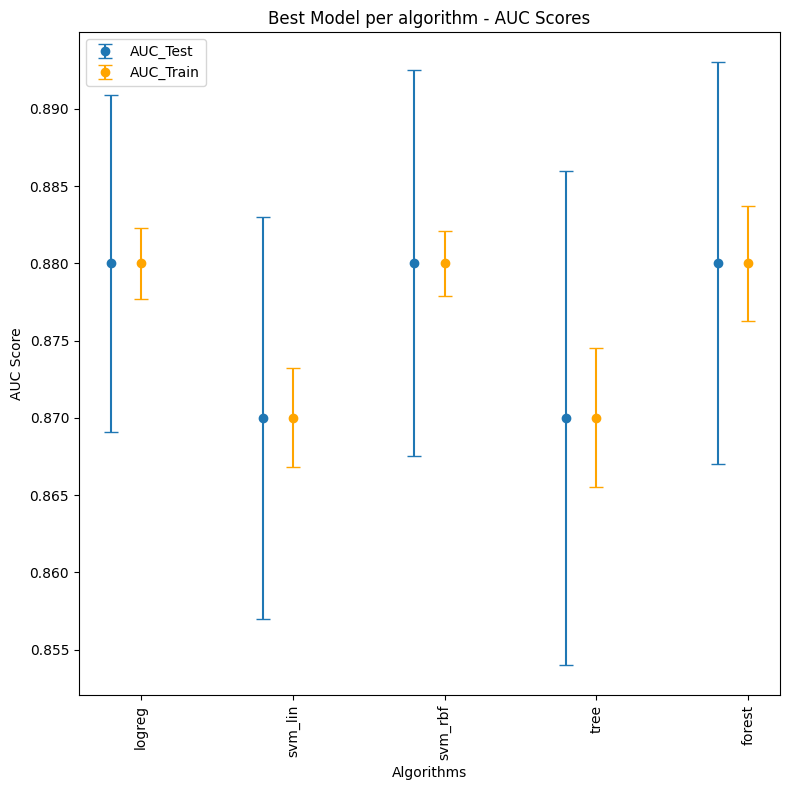

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [41]:
#start nested k-fold cross validation for each algorithm

algorithms = zip(grids, pipes, classifiers_name)

best_gridsearch_models, df_results_overview = find_best_models_per_algo(X_train, y_train, algorithms)

## Model Evaluation

### General

In [42]:
#show best parameter combinations for each chosen (best) model

for model in best_gridsearch_models:
  display(model[1])

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('minmax',
                                                                   MinMaxScaler()),
                                                                  ('z_score',
                                                                   StandardScaler())]),
                                                  [0, 1]),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  [3, 2]),
                                                 ('bin',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ord_encoder',
                                                                   OrdinalEncoder())]),
                                                  [4, 5, 6])])),
                ('logreg',
                 LogisticRegression(C=1, class_weight='balanced', max_iter=1000,
                                    random_state=42, solver='liblinear'))])

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('minmax',
                                                                   MinMaxScaler()),
                                                                  ('z_score',
                                                                   StandardScaler())]),
                                                  [0, 1]),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  [3, 2]),
                                                 ('bin',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ord_encoder',
                                                                   OrdinalEncoder())]),
                                                  [4, 5, 6])])),
                ('svm_lin',
                 SVC(C=100, class_weight='balanced', kernel='linear',
                     probability=True, random_state=42))])

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('minmax',
                                                                   MinMaxScaler()),
                                                                  ('z_score',
                                                                   StandardScaler())]),
                                                  [0, 1]),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  [3, 2]),
                                                 ('bin',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ord_encoder',
                                                                   OrdinalEncoder())]),
                                                  [4, 5, 6])])),
                ('svm_rbf',
                 SVC(C=1, class_weight='balanced', gamma=0.01, probability=True,
                     random_state=42))])

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('minmax',
                                                                   MinMaxScaler()),
                                                                  ('z_score',
                                                                   StandardScaler())]),
                                                  [0, 1]),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  [3, 2]),
                                                 ('bin',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ord_encoder',
                                                                   OrdinalEncoder())]),
                                                  [4, 5, 6])])),
                ('tree',
                 DecisionTreeClassifier(class_weight='balanced',
                                        criterion='entropy', max_depth=3,
                                        min_samples_leaf=3, random_state=42))])

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('minmax',
                                                                   MinMaxScaler()),
                                                                  ('z_score',
                                                                   StandardScaler())]),
                                                  [0, 1]),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  [3, 2]),
                                                 ('bin',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ord_encoder',
                                                                   OrdinalEncoder())]),
                                                  [4, 5, 6])])),
                ('forest',
                 RandomForestClassifier(class_weight='balanced',
                                        criterion='entropy', min_samples_leaf=9,
                                        n_estimators=850, random_state=42))])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

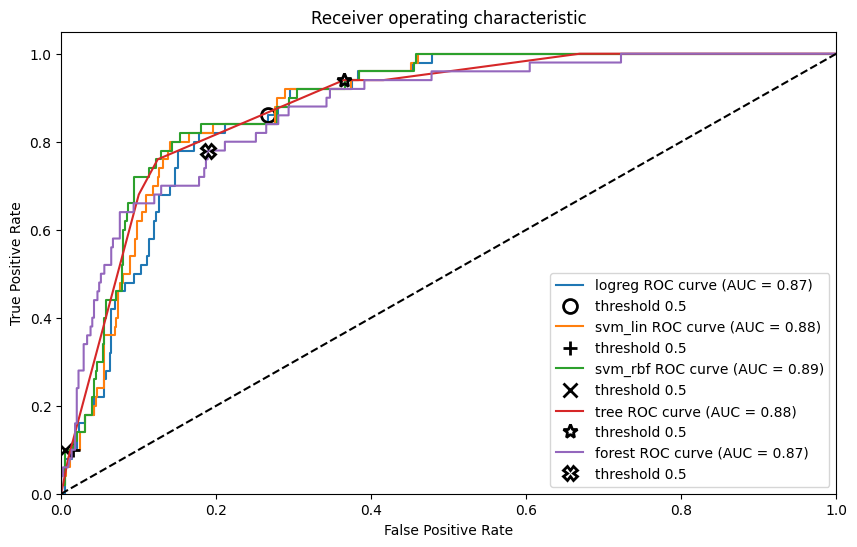

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [43]:
#create and save ROC curve of the best parameter combination for each algorithm identified by nested-k-fold

fprs, tprs, thresholds, identifiers = [], [], [], []

for best_model in best_gridsearch_models:

  best_model[1].fit(X_train, y_train)
  y_pred = best_model[1].predict(X_test)

  confidence_in_y_pred, confidence_type = get_proba_score(best_model[1], X_test)

  fpr, tpr, threshold = roc_curve(y_test, confidence_in_y_pred, pos_label=1)
  fprs.append(fpr)
  tprs.append(tpr)
  thresholds.append(threshold)

  identifiers.append(best_model[0])

auc_scores = plot_roc_curves(fprs, tprs, thresholds, identifiers)

df_results_overview['AUC Score_final Test'] = pd.DataFrame(auc_scores)
create_csv_file(df_results_overview, 'results_overview')


<ipython-input-47-aff0ee4a97a6>:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['1','2', '3', '4', '5', '6', '7'])


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

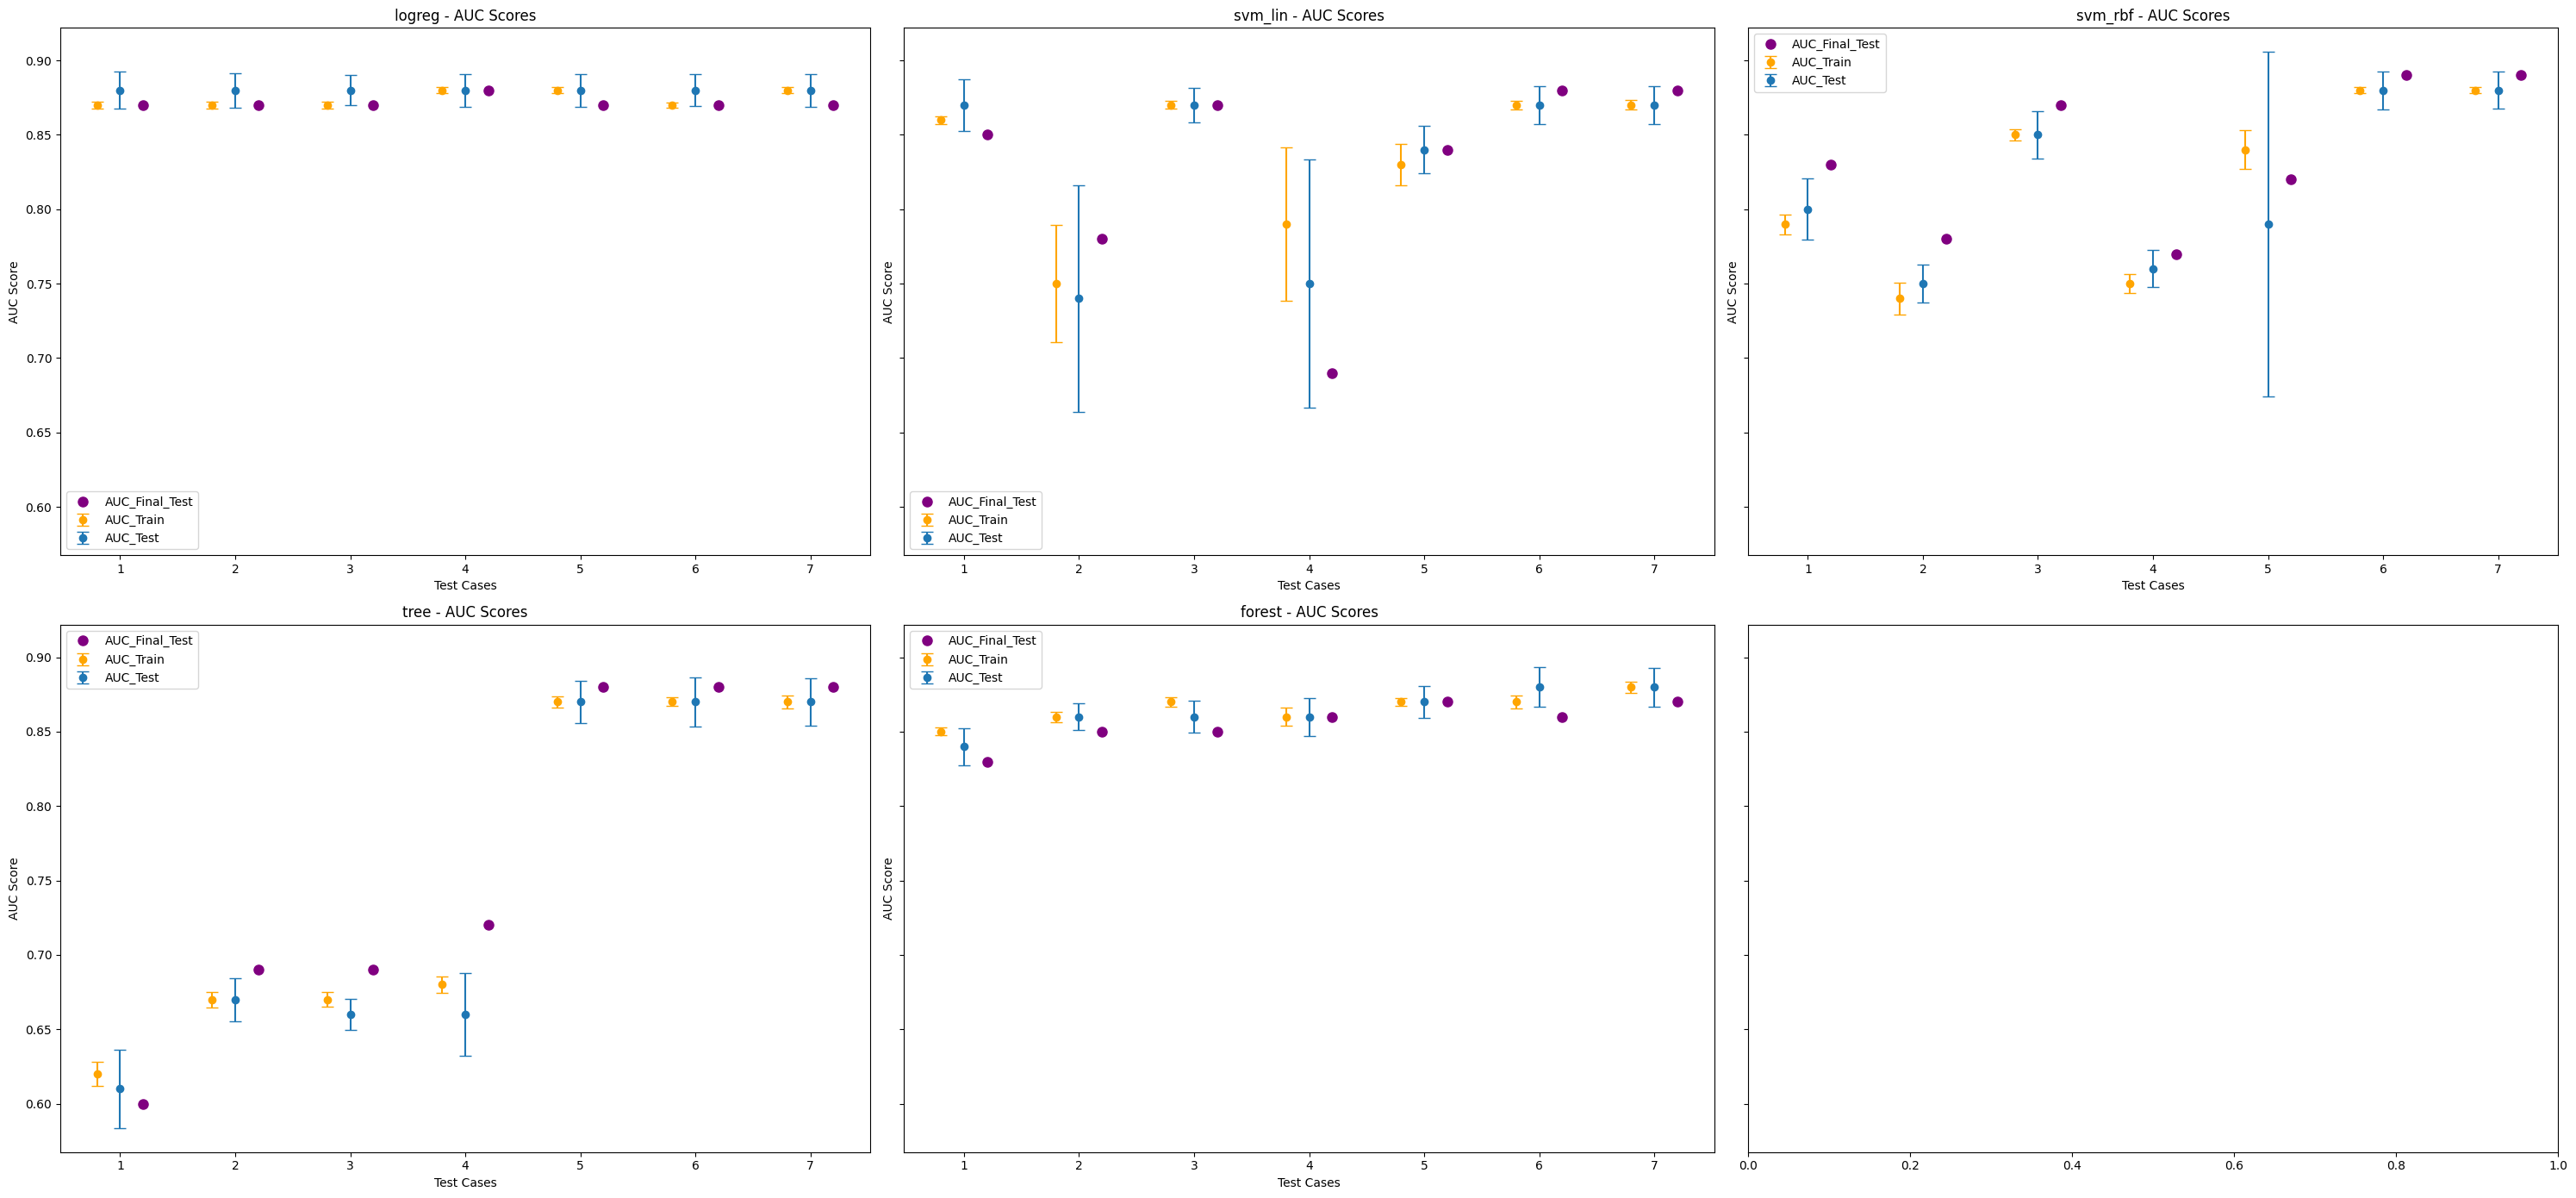

In [48]:
df_results = import_data(URL_RESULTS, 0)

desired_order = ['base', 'winsorizing_outliers', 'class_weights', 'drop_smoking_status', 'tuning', 'tuning_drop_smoking_class_weights', 'tuning_drop_smoking_and_bmi_class_weights']
df_results = df_results.set_index('Szenario').loc[desired_order].reset_index()

desired_order = ['logreg', 'svm_lin', 'svm_rbf','tree', 'forest']
df_results = df_results.set_index('Classifier').loc[desired_order].reset_index()

algorithms = df_results['Classifier'].unique()

ncols = 3
nplots = len(models)
nrows = (nplots // ncols) + 1

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, sharey=True, figsize=(30,14))
axes = axes.flatten()

#iterate through each algorithm and create error bar plot for all testcases
for i, algorithm in enumerate(algorithms):
    df_tmp = df_results[df_results['Classifier'] == algorithm]
    plot_errorbars(df_tmp['Szenario'], df_tmp[' Mean AUC Score_Test'], df_tmp['Standard Deviation_Test'], df_tmp[' Mean AUC Score_Train'], df_tmp['Standard Deviation_Train'], df_tmp['AUC Score_final Test'], 'Test Cases', algorithm, axes[i]);


save_plot(fig, "results_test cases")

plt.tight_layout()
plt.show()

### Feature Importance

In [49]:
threshold = 0.0001

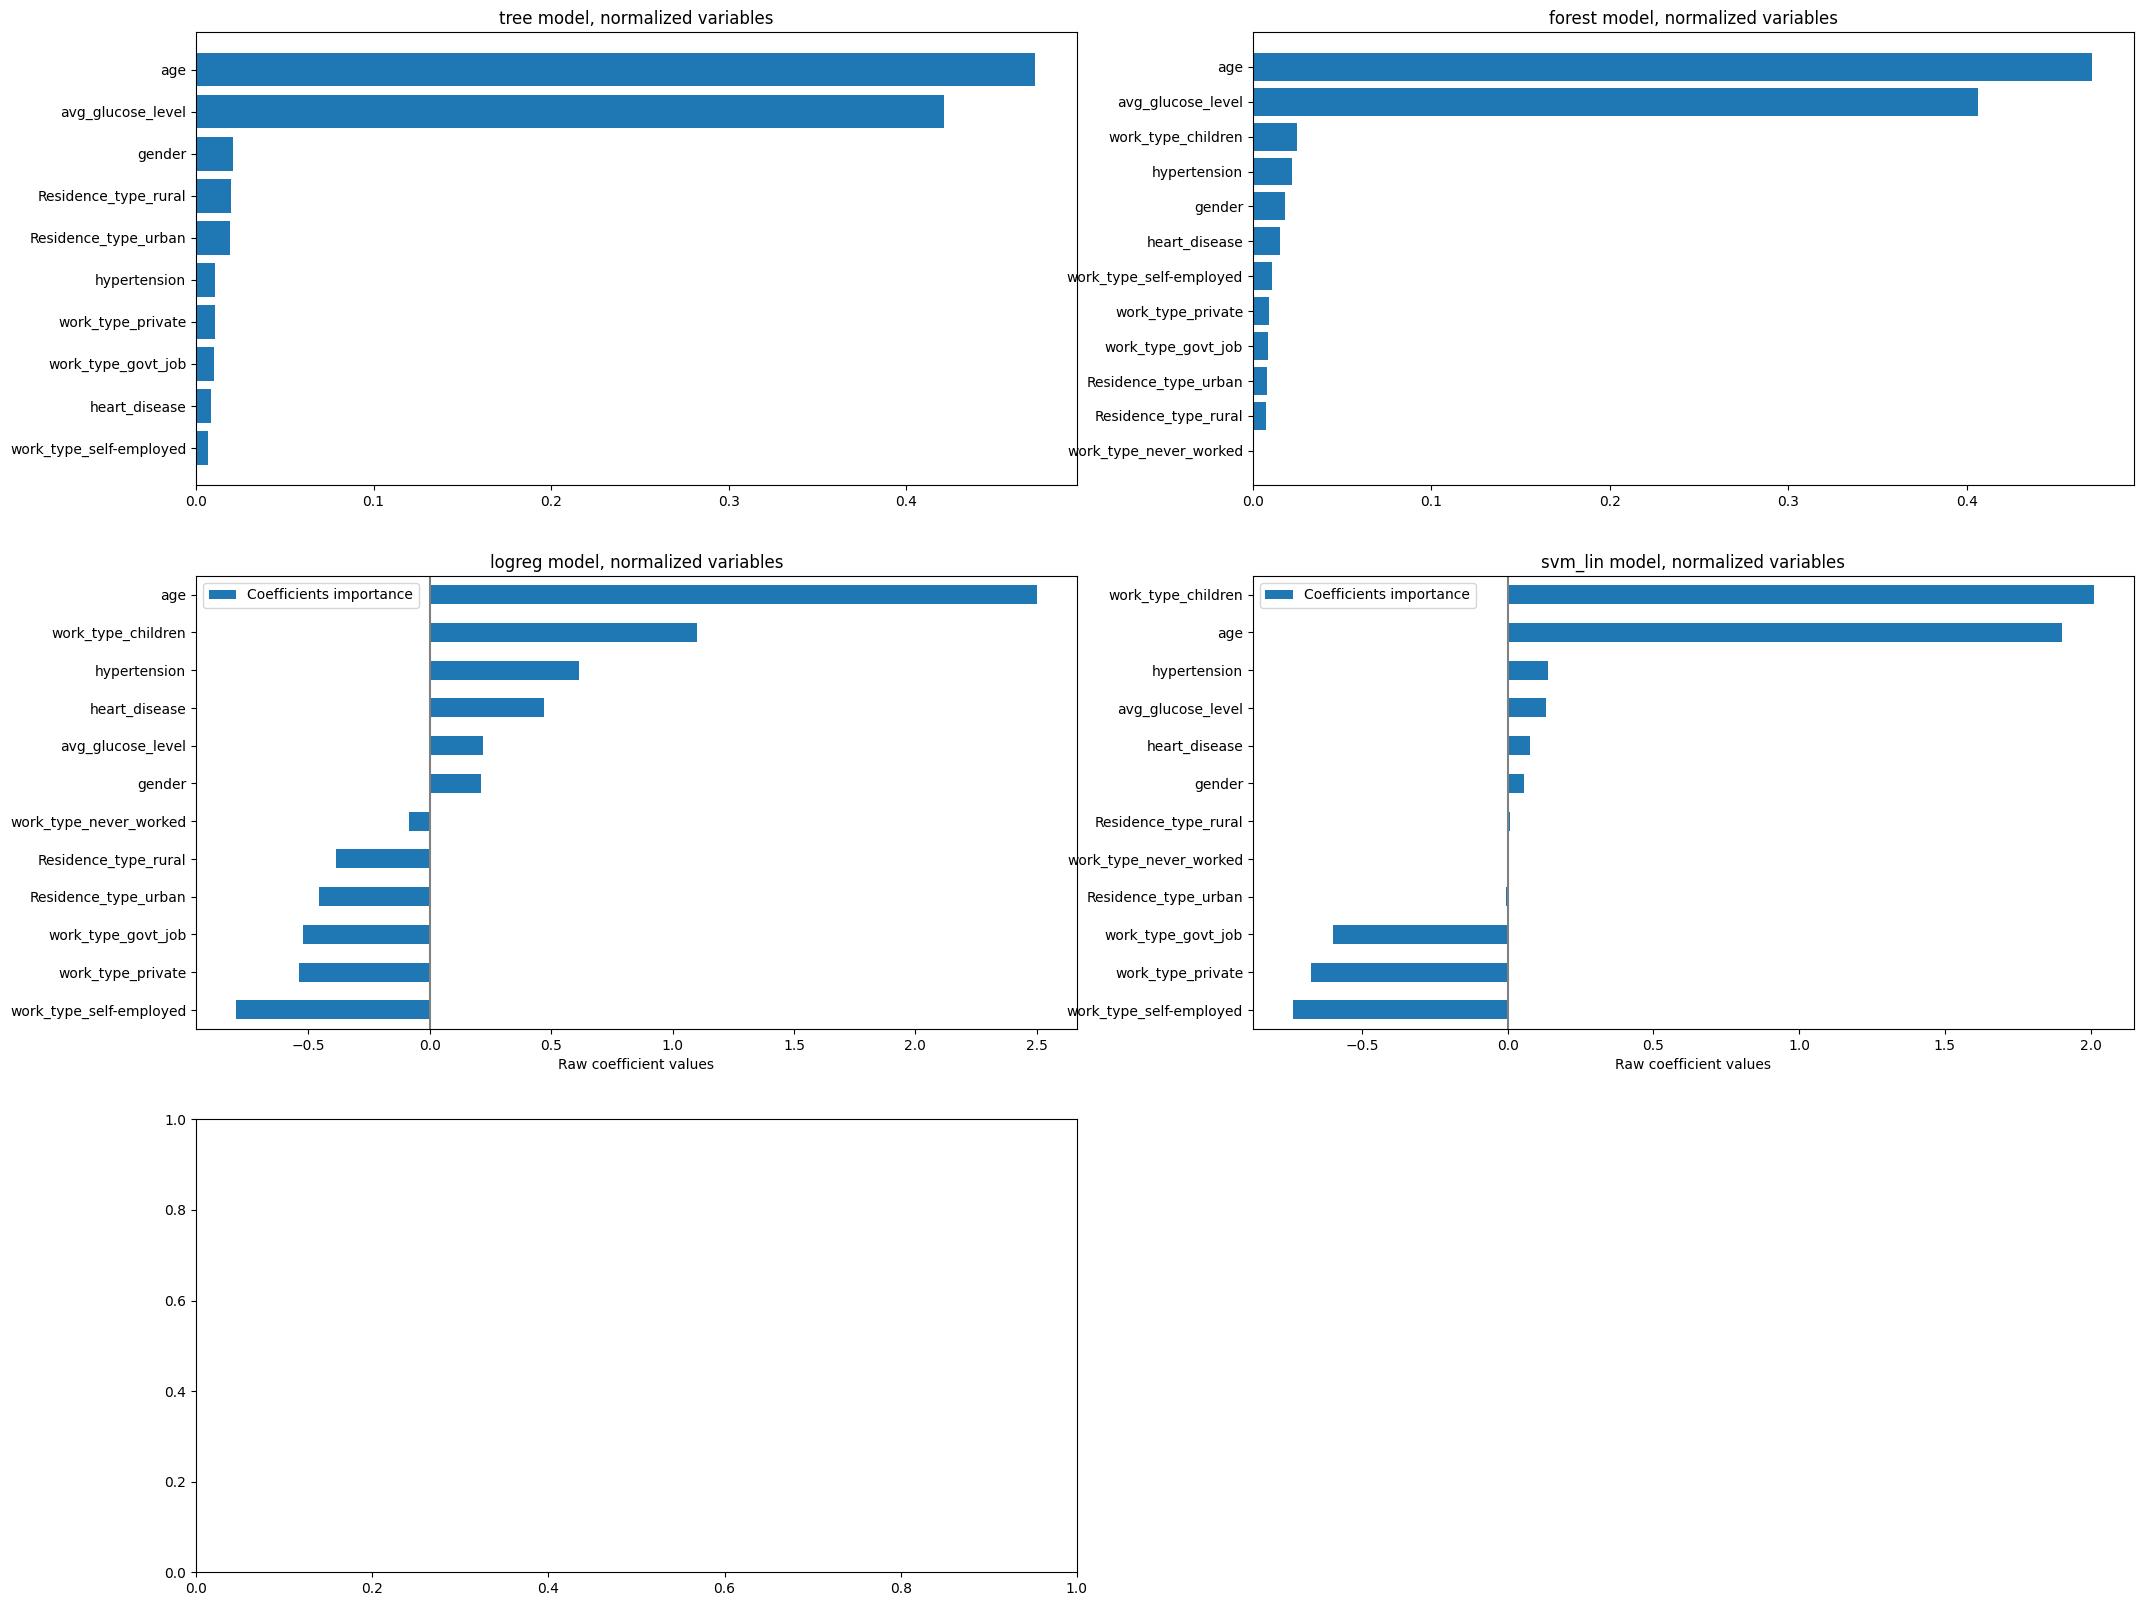

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [50]:
ncols = 2
nplots = len(best_gridsearch_models)
nrows = (nplots // ncols) + 1


fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(25,20))
axes = axes.flatten()

### Tree
tree_clf = tree_pipe.named_steps['tree']
tree_pipe.fit(X_train, y_train)
feature_names_after_pipe = get_feature_names_after_pipe(tree_pipe)
get_feature_performance(tree_clf, threshold, feature_names_after_pipe, 'tree', axes[0])

### Random Forest
forest_clf = forest_pipe.named_steps['forest']
forest_pipe.fit(X_train, y_train)
get_feature_performance(forest_clf, threshold, feature_names_after_pipe, 'forest', axes[1])


### Logistic Regression
logreg_clf = logreg_pipe.named_steps['logreg']
logreg_pipe.fit(X_train, y_train)
coefficients = np.array(logreg_clf.coef_).reshape(-1, 1)
plot_feature_importance_linear_models(coefficients, feature_names_after_pipe, 'logreg', axes[2])


### Linear SVM
svm_lin_clf = svm_lin_pipe.named_steps['svm_lin']
svm_lin_pipe.fit(X_train, y_train)
coefficients = np.array(svm_lin_clf.coef_).reshape(-1, 1)
plot_feature_importance_linear_models(coefficients, feature_names_after_pipe, 'svm_lin', axes[3])

remove_empty_subplots(nplots, axes, fig)
plt.tight_layout()
plt.show()

save_plot(fig, "feature importance")
